# Topic Modeling and sentiment analaysis

## Topic modeling

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

Dimensionality Reduction, where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}



There are several existing algorithms we can use to perform the topic modeling. The most common of it are, Latent Semantic Analysis (LSA/LSI), Probabilistic Latent Semantic Analysis (pLSA), and Latent Dirichlet Allocation (LDA)


In this article, we’ll take a closer look at LDA, and implement our first topic model using the sklearn implementation in python.

# LDA Implementation

The steps used to implement LDA :
   1) Loading data
   
   2) Data cleaning
   
   
   3) Exploratory analysis
   
   
   4) Preparing data for LDA analysis
   
   
   5) LDA model training
   
   
   6) Analyzing LDA model results

# Step 1: Loading Data 

In [7]:
# Importing modules
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re

#os.chdir('..')

# Read data into papers
papers = pd.read_csv('processed_tweet_data .csv')

# Print head
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


# Step 2: Data Cleaning

Since the goal of this analysis is to perform topic modeling, let's focus only on the text data from each paper, and drop other metadata columns.

In [8]:
# Remove the columns
papers = papers.drop(columns=['favorite_count','possibly_sensitive','user_mentions'], axis=1).sample(100)

# Print out the first rows of papers
papers.head()

,created_at,source,original_text,polarity,subjectivity,lang,retweet_count,original_author,followers_count,friends_count,hashtags,place
1298,Fri Jun 18 19:36:01 +0000 2021,"<a href=""https://help.twitter.com/en/using-twi...",Pin Code:[411015] \nKASTURBA SPECIALITY HOSPIT...,-0.7500,1.000,en,0,PuneUpdater,88,0,[],NaN
3786,Sat Jun 19 01:04:15 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","204,344 #COVID19 vaccines have been administer...",0.3375,0.725,en,62,ms_christinak,207,219,"[{'text': 'COVID19', 'indices': [25, 33]}]",she from the 🇨🇦
1343,Fri Jun 18 19:39:51 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Double Platinum on sight. Let's go 💿,0.0000,0.000,en,0,TokyoDibz,1186,759,[],Cape
3237,Fri Jun 18 23:37:02 +0000 2021,"<a href=""https://help.twitter.com/en/using-twi...",Pin Code:[411004] \nBMCC-DEENANATH HOSPITAL PV...,-0.7500,1.000,en,0,PuneUpdater,88,0,[],NaN
4253,Sat Jun 19 02:19:03 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Border CROSSING: “This provision is in place t...,0.0000,0.000,en,0,tribalassets,1481,44,[],NorthAmerica


## Remove punctuation/lower casing

In [9]:
# Load the regular expression library

import re

# Remove punctuation

papers['paper_text_processed'] = \
papers['original_text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase

papers['paper_text_processed'] = \
papers['paper_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers

papers['paper_text_processed'].head()


1298    pin code:[411015] \nkasturba speciality hospit...
3786    204344 #covid19 vaccines have been administere...
1343                  double platinum on sight let's go 💿
3237    pin code:[411004] \nbmcc-deenanath hospital pv...
4253    border crossing: “this provision is in place t...
Name: paper_text_processed, dtype: object

# Step 3: Exploratory Analysis

To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

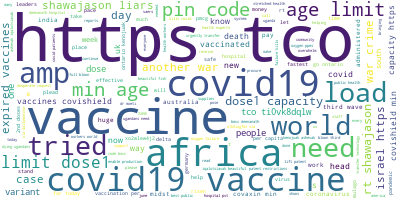

In [10]:
# Import the wordcloud library

from wordcloud import WordCloud

# Join the different processed titles together.

long_string = ','.join(list(papers['paper_text_processed'].values))

# Create a WordCloud object

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud

wordcloud.generate(long_string)

# Visualize the word cloud

wordcloud.to_image()

# Step 4 Prepare data for LDA Analysis

Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [11]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])


['pin', 'code', 'kasturba', 'speciality', 'hospital', 'vaccines', 'covishield', 'min', 'age', 'limit', 'dose', 'capacity', 'https', 'tco', 'affji', 'pfge']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eyerusalem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]


/home/eyerusalem/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Step 5: LDA model tranining 

keeping all the parameters to default except for inputting the number of topics, its time to build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic. 

In [21]:
from pprint import pprint

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/home/eyerusalem/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.043*"vaccines" + 0.041*"tco" + 0.040*"https" + 0.025*"rt" + 0.021*"crime" '
  '+ 0.021*"another" + 0.021*"load" + 0.021*"tried" + 0.021*"shawajason" + '
  '0.021*"israel"'),
 (1,
  '0.036*"covid" + 0.035*"https" + 0.034*"tco" + 0.023*"africa" + '
  '0.020*"vaccines" + 0.017*"amp" + 0.016*"cases" + 0.015*"australia" + '
  '0.013*"wave" + 0.012*"risen"'),
 (2,
  '0.023*"vaccines" + 0.023*"get" + 0.021*"africa" + 0.017*"vaccinated" + '
  '0.017*"covid" + 0.012*"tco" + 0.012*"vaccination" + 0.012*"https" + '
  '0.012*"please" + 0.011*"getting"'),
 (3,
  '0.029*"vaccines" + 0.025*"africa" + 0.025*"https" + 0.024*"tco" + '
  '0.021*"covid" + 0.017*"world" + 0.012*"ontario" + 0.011*"health" + '
  '0.010*"need" + 0.008*"people"'),
 (4,
  '0.043*"need" + 0.034*"world" + 0.031*"covid" + 0.029*"oxygen" + '
  '0.016*"vaccines" + 0.016*"https" + 0.016*"tco" + 0.015*"stretched" + '
  '0.015*"via" + 0.015*"ppes"'),
 (5,
  '0.041*"tco" + 0.041*"vaccines" + 0.040*"https" + 0.021*"covid" + '
 

# Step 6: Analyzing our LDA model 

Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

 1) Better understanding and interpreting individual topics, and       
 2) Better understanding the relationships between the topics.

In [24]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/home/eyerusalem/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.190885  0.020085       1        1  19.992913
3      0.091813  0.093706       2        1  19.636628
5     -0.104068  0.000434       3        1  14.509979
7     -0.048316  0.057190       4        1  11.898511
1      0.015816 -0.160051       5        1  10.689064
4      0.059861  0.000724       6        1   6.253291
8     -0.036940  0.012264       7        1   4.585758
6      0.041718 -0.072401       8        1   4.373920
2      0.089046  0.008807       9        1   4.072240
9      0.081954  0.039243      10        1   3.987696, topic_info=          Term       Freq      Total Category  logprob  loglift
65      africa  20.000000  20.000000  Default  30.0000  30.0000
73        need  13.000000  13.000000  Default  29.0000  29.0000
39       world  14.000000  14.000000  Default  28.0000  28.0000
7        https  67.000000  67.000000  Default  27.0000  27.0000
14         tco  68.000000  68.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
265       wave   0.528902   4.884624  Topic10  -5.0149   0.9989
578  equitably   0.528900   1.971344  Topic10  -5.0149   1.9063
203       well   0.528896   2.059191  Topic10  -5.0149   1.8627
224         rt   0.528895  14.176995  Topic10  -5.0149  -0.0666
201   together   0.528891   2.005948  Topic10  -5.0149   1.8889

[520 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
86        7  0.534442        access
514       5  0.507189        across
16        2  0.660721  administered
16        4  0.220240  administered
500       7  0.842902      advocacy
...     ...       ...           ...
134       2  0.811277          xsjd
618       1  0.656960     yesterday
428       3  0.655662           yfb
85        5  0.499325           ylr
245       4  0.486907           zip

[637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 6, 8, 2, 5, 9, 7, 3, 10])